# Etude de la vitesse de remplissage de pores 

--------------------------------------------------------------------------
Ce notebook rend compte de la modélisation de la vitesse de remplissage de l'electrolyte pour structures non-calendrées, en fonction de la configuration en un réseau de pores de cette même électrode. L'ensemble des données est issu de simulations $\textit{LBM}$ pré-traité sous Python.

----------------------------------------------------------------------------
<br>
L'étude tient compte de l'analyse quantitative des données récoltées afin de construire une base de données permettant la modélisation via un réseau de neurones multi-couches, dit $\textit{Multi-Layers Perceptron}$
<br>
Le but de cette étude est de pouvoir utiliser le modèle entrainé pour prédire la vitesse de l'électrolyte pour des structures totalement nouvelles, évitant ainsi le calcule de simulations extrêmement couteuses en termes de ressources informatiques.

##### Ressources Python

In [27]:
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import initializers
import matplotlib.gridspec as gridspec
from sklearn.metrics import r2_score
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy import interpolate
from tensorflow import keras
from sklearn import metrics
from scipy import ndimage
import tensorflow as tf
import pandas as pd
import numpy as np
import warnings
import random
import pickle
import os

warnings.filterwarnings("ignore")

###### Chargement des données nécessaires

In [23]:
with open('../ressources/Informations-REAL.pkl', 'rb') as f:
    y = pickle.load(f)
with open('../ressources/x-REAL.pkl', 'rb') as f:
    X = pickle.load(f)

##### Traitement des données

In [24]:
def Normalize(x):
    
    return (x - m) / (M - m)

In [25]:
X['Y0'] = pd.DataFrame(y).iloc[:, 2]
X['Y1'] = pd.DataFrame(y).iloc[:, 4]
X['Y2'] = pd.DataFrame(y).iloc[:, 1]
idx=[]
for i in range(X.shape[0]):
    if "nan" != str(X.iloc[i,7]):
        idx.append(i)
X = X.iloc[idx, :]
X=X[X['Y1'] != "Error"]
old_version = X['Y1']
X['Y1'] = [np.log(i) for i in X['Y1']]
m, M = min(X['Y1']), max(X['Y1'])
X['Y1'] = X['Y1'].apply(Normalize)

La distribution des valeurs de vélocités est extrêment hétéroscdastique, ce qui induit un biais dans la modélisation. Une transformation des données par le processus de $\textit{Box-Cox}$ [[1]]( https://blog.minitab.com/fr/en-quoi-la-transformation-box-cox-peut-vous-etre-utile) permet à la variable "velocité" d'être assimilée à une distribution plus Gaussienne.<br>
Cependant, cette transformation sera normalisée (entre 0 et 1) à la suite de plusieurs tests de modélisation. En effet, il se trouve que le réseau de neurones a parfaitement modélisé cette transformation normalisée.
<br>
<center> $Y_{mod} = \frac{log(V_0) - m}{M-m}$</center>
<br>
Où $V_0$ représente la vélocité initiale, et $m, M$ le minimum et maximum de la distribution.

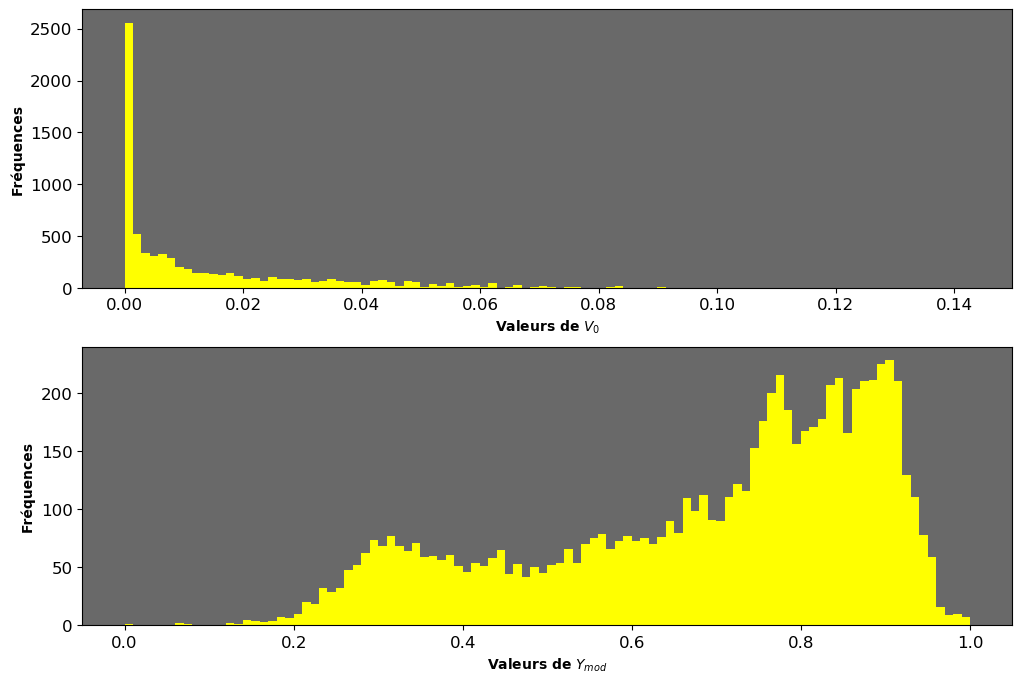

In [90]:
plt.style.use("default")
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(hspace = .21, wspace=.05)
gs1 = gridspec.GridSpec(2, 1)
axs = []

axs.append(fig.add_subplot(gs1[1]))
ax = plt.gca()
ax.set_facecolor('dimgrey')
_=ax.hist(X['Y1'], bins=100, color='yellow')
_=plt.xticks(fontsize=12)
_=plt.yticks(fontsize=12)
_=plt.xlabel('Valeurs de $Y_{mod}$', fontweight='bold')
_=plt.ylabel('Fréquences', fontweight='bold')
axs.append(fig.add_subplot(gs1[0]))
ax = plt.gca()
ax.set_facecolor('dimgrey')
_=ax.hist(old_version, bins=100, color='yellow')
_=plt.yticks(fontsize=12)
_=plt.xticks(fontsize=12)
_=plt.xlabel('Valeurs de $V_0$', fontweight='bold')
_=plt.ylabel('Fréquences', fontweight='bold')

##### Mise en place de l'entrainement du réseau de neurones

Les données sont séparées en un base d'entrainement et de test selon un ratio de 80%. La base d'entrainement se verra grossir à l'aide de données rajoutéées de manière aléatoire, parmi celles en queue de distribution. Cet ajout permet au modèle de mieux modéliser les valeurs de vélocité faiblement représentées dans la distribution.
<br>
Les données d'entrées sont normalisées afin d'avoir des valeurs suivant une distribution Gaussienne.

In [88]:
Train, Test = train_test_split(X[['Pressure', 'Pixels', 'NFace', 'NFace_c', 'Ratio', 'Centre', 'Y1', 'Y2']], train_size=0.80)

n0, n1 = Train[Train['Y1'] <= 0.2].shape[0], Train[Train['Y1'] <= 0.2].shape[0]

oversampling = Train[Train['Y1'] <= 0.2].reset_index(drop=True)
lst=[random.sample(oversampling.index.tolist(), 1)[0] for i in range(int((n1-n0)/2))]

Train = pd.concat([Train.reset_index(drop=True),
                      oversampling.iloc[lst, :].reset_index(drop=True)], axis=0,
          ignore_index=True)
Train.columns = ['Pressure', 'Pixels', 'NFace', 'NFace_c', 'Ratio', 'Centre', 'Y1', 'Y2']

XTrain = Train[['Pressure', 'Pixels', 'NFace', 'NFace_c', 'Ratio', 'Centre']]
YTrain = Train[['Y1']]
XTest = Test[['Pressure', 'Pixels', 'NFace', 'NFace_c', 'Ratio', 'Centre']]
YTest = Test[['Y1']]

scaler = StandardScaler().fit(XTrain)
XTrain = scaler.transform(XTrain)
XTest = scaler.transform(XTest)

mu, sigma = np.mean(YTrain), np.sqrt(np.var(YTrain))

Le réseau se compose des couches suivantes :
- 5 couches cachées avec chacune 80 neurones.
- Après chaque couche cachée, les données sont normalisées avec la couche "BatchNormalization".
- La couche de sortie possède un seul neuronne où la fonction d'activation est une sigmoid.

In [89]:
model = keras.Sequential([
            layers.Dense(80, activation=tf.nn.relu, input_shape=[XTrain.shape[1]],
                         bias_initializer=initializers.RandomNormal(mean=np.mean(mu),stddev=np.mean(sigma))),
            layers.BatchNormalization(),
            layers.Dense(80, activation=tf.nn.relu,
                         bias_initializer=initializers.RandomNormal(mean=np.mean(mu),stddev=np.mean(sigma))),
            layers.BatchNormalization(),
            layers.Dense(80, activation=tf.nn.relu,
                         bias_initializer=initializers.RandomNormal(mean=np.mean(mu),stddev=np.mean(sigma))),
            layers.BatchNormalization(),
            layers.Dense(80, activation=tf.nn.relu,
                         bias_initializer=initializers.RandomNormal(mean=np.mean(mu),stddev=np.mean(sigma))),
            layers.BatchNormalization(),
            layers.Dense(80, activation=tf.nn.relu,
                         bias_initializer=initializers.RandomNormal(mean=np.mean(mu),stddev=np.mean(sigma))),
            layers.BatchNormalization(),
            layers.Dense(1, activation=tf.nn.sigmoid),
        ])

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])


early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='mse',
            verbose=0,
            patience=1000,
            mode='max',
            restore_best_weights=True)

history = model.fit(np.asarray(XTrain).astype('float64'), np.asarray(YTrain).astype('float64'),
          epochs=1000, validation_data=(np.asarray(XTest).astype('float64'),
                                       np.asarray(YTest).astype('float64')), callbacks=[early_stopping],
                  verbose=1)

Epoch 1/1000
186/186 [==============================] - 1s 8ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 2/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 3/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 4/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 5/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 6/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 7/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 8/1000
186/186 [==============================] - 1s 7ms

Epoch 62/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 63/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 64/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 65/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 66/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 67/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 68/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 69/1000
186/186 [==============================] 

186/186 [==============================] - 1s 7ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 123/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 124/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 125/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 126/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 127/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 128/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 129/1000
186/186 [==============================] - 1s 6m

186/186 [==============================] - 1s 6ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 183/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 184/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 185/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 186/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 187/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 188/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 189/1000
186/186 [==============================] - 1s 6m

186/186 [==============================] - 1s 7ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 243/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 244/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 245/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 246/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 247/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 248/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 249/1000
186/186 [==============================] - 1s 7m

186/186 [==============================] - 1s 7ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 303/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 304/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 305/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 306/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 307/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 308/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 309/1000
186/186 [==============================] - 1s 7m

186/186 [==============================] - 1s 7ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 363/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 364/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 365/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 366/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 367/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 368/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 369/1000
186/186 [==============================] - 1s 6m

186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 423/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 424/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 425/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 426/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 427/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 428/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 429/1000
186/186 [==============================] - 1s 7m

186/186 [==============================] - 1s 6ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 483/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 484/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 485/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 486/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 487/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 488/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 489/1000
186/186 [==============================] - 1s 7m

186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 543/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 544/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 545/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 546/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 547/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 548/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 549/1000
186/186 [==============================] - 1s 7m

186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 603/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 604/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 605/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 606/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 607/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 608/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 609/1000
186/186 [==============================] - 1s 6m

186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 663/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 664/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 665/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 666/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 667/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 668/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 669/1000
186/186 [==============================] - 1s 7m

186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 723/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 724/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 725/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 726/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 727/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 728/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 729/1000
186/186 [==============================] - 1s 6m

186/186 [==============================] - 1s 7ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 783/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 784/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 785/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 786/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 787/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 788/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 789/1000
186/186 [==============================] - 1s 6m

186/186 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 843/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 844/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 845/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 846/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 847/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 848/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 849/1000
186/186 [==============================] - 1s 7m

186/186 [==============================] - 1s 6ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 903/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 904/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 905/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 906/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 907/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 908/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 909/1000
186/186 [==============================] - 1s 6m

186/186 [==============================] - 1s 7ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 963/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 964/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 965/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 966/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 967/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 968/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 969/1000
186/186 [==============================] - 1s 7m

##### Validation du modèle
Le coéfficient de régression rend compte de la qualité du modèle pour de nouvelles données que le modèle n'a pas eu à traiter dans sa phase d'entrainement.

In [91]:
predictions = history.model.predict(XTest)
print("R² = %0.4f" % r2_score(YTest, predictions))

R² = 0.9551


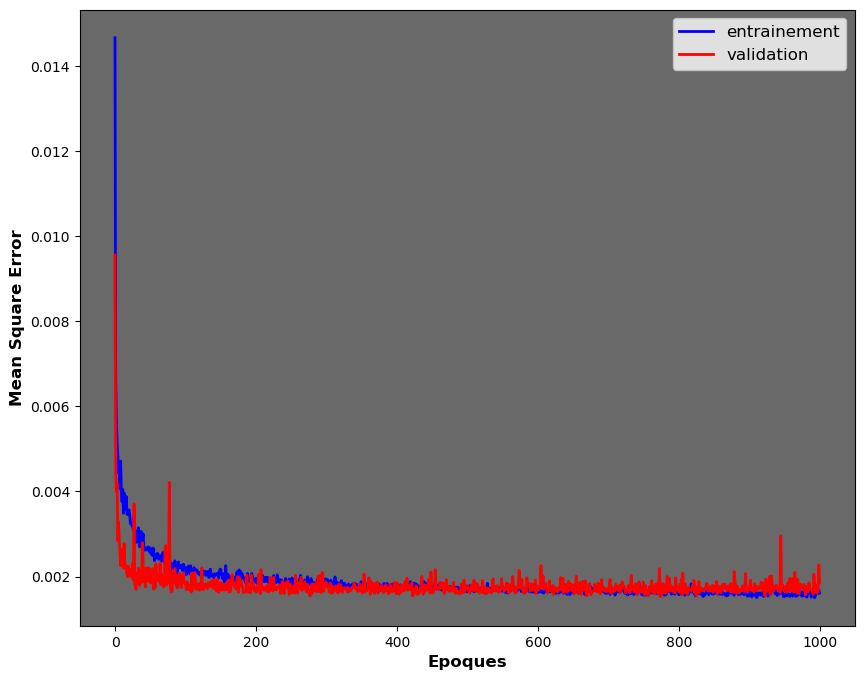

In [95]:
plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.set_facecolor('dimgrey')
plt.plot(history.history['mse'], "b-", lw=2, label="entrainement")
plt.plot(history.history['val_mse'], "r-", lw=2, label="validation")
plt.xlabel('Epoques', fontsize=12, fontweight="bold")
plt.ylabel('Mean Square Error', fontsize=12, fontweight="bold")
plt.legend(loc="upper right", fontsize=12)
plt.show()

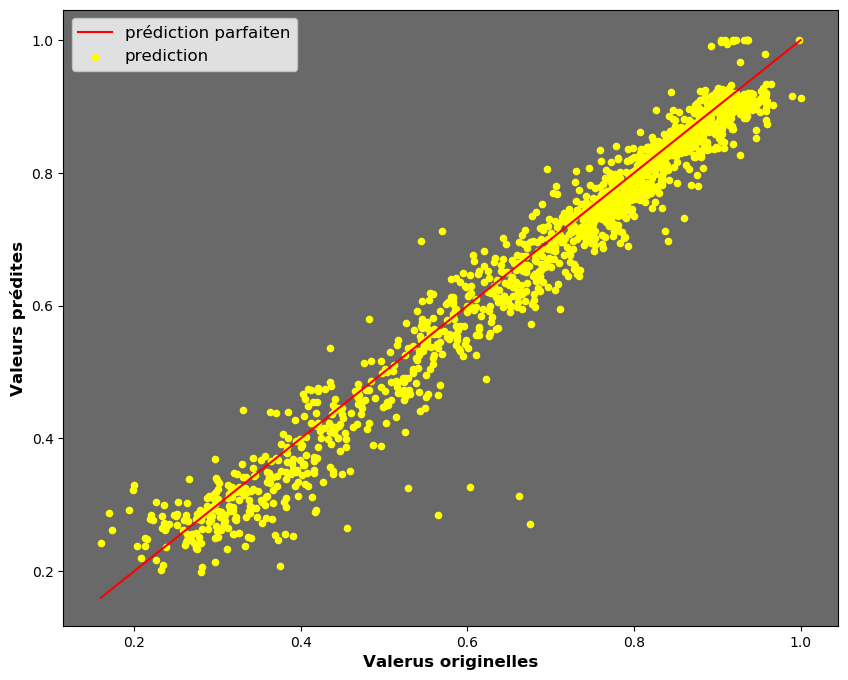

In [99]:
plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.set_facecolor('dimgrey')
plt.scatter(YTest.iloc[:, 0], history.model.predict(XTest)[:, 0], c="yellow", s=20,
            label="prediction")
plt.plot([min(YTest.iloc[:, 0]), max(YTest.iloc[:, 0])],[min(YTest.iloc[:, 0]), max(YTest.iloc[:, 0])], 'r-',
         label="prédiction parfaiten")
plt.xlabel('Valerus originelles', fontsize=12, fontweight="bold")
plt.ylabel('Valeurs prédites', fontsize=12, fontweight="bold")
plt.legend(loc="upper left", fontsize=12)
plt.show()

##### Analyse de sensitivité
Une analyse de sensitivité du modèle permet de donner la variation de la sortie, en fonction de celle d'une des variables d'entrée du modèle. Pour cela, on utilise les indices de Sobol [[2]](https://www.gdr-mascotnum.fr/media/gdr_mascot_num09_cmattrand.pdf) :
<br>
<center> $S_i := \frac{Var[E(Y_{mod} | X_i)]}{Var[Y_{mod}]}$ </center>
<br>
où $i$ représente le numéro de la variable d'entrée.

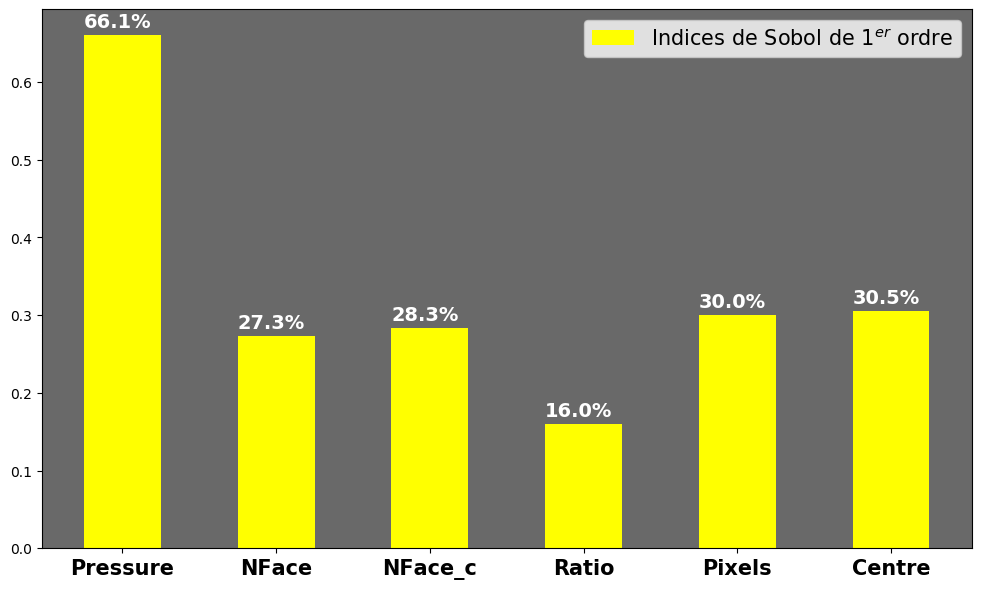

In [149]:
plt.figure(figsize=(12, 7))
ax = plt.gca()
ax.set_facecolor('dimgrey')
plt.bar([0,1,2,3,4,5], [np.var(Train.groupby(i)['Y1'].mean()) / np.var(Train['Y1']) for i in Train.columns[:6]],
        0.5, label='Indices de Sobol de $1^{er}$ ordre', color='yellow')
for i,j in zip(Train.columns[:6], range(6)):
    plt.annotate(str(round(np.var(Train.groupby(i)['Y1'].mean()) / np.var(Train['Y1'])*100, 1))+"%",
                 xy=(j-0.25,
                     np.var(Train.groupby(i)['Y1'].mean()) / np.var(Train['Y1'])+0.01),
                 fontweight='bold', color="white", fontsize=14)
_=plt.xticks(range(6), labels=['Pressure', "NFace", "NFace_c", "Ratio", "Pixels", "Centre"], fontsize=15,
            fontweight="bold")
_=plt.legend(fontsize=15)

##### Test sur de nouvelles données
Le modèle étant sauvegardé, il faut pouvoir réutiliser les ressources de noramlisation et de prédiction pour de nouvelles structures.

In [53]:
model = tf.keras.models.load_model("../output/validated_model")
with open('../output/scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
with open('../output/indexdetest.pkl', 'rb') as f:
        idx = pickle.load(f)
with open('../output/history.pkl', 'rb') as f:
        hist = pickle.load(f)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7fd0886b4d10> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fd0a0041d50>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fd0a0041d50> and <tensorflow.python.keras.layers.core.Dense object at 0x7fd08867a310>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7fd08867a310> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fd0886833d0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fd0886833d0> and <tensorflow.python.keras.layers.core.Dense object at 0x7fd088692a10>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.co

In [ ]:
XTest_new = scalar.transform(XTest_new)
predictions_new = model.predict(XTest_new)

In [ ]:
print("R² = %0.4f" % r2_score(YTest_new, predictions_new))

In [ ]:
plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')

plt.scatter(YTest_new, model.predict(XTest_new)[:, 0], c="mediumblue", s=20,
            label="prediction")
plt.plot([min(YTest_new), max(YTest_new)],[min(YTest_new), max(YTest_new)], 'r-',
         label="perfect prediction")
plt.xlabel('True values', fontsize=12, fontweight="bold")
plt.ylabel('Predicted values', fontsize=12, fontweight="bold")
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [10]:
X['Y0'] = pd.DataFrame(y).iloc[:, 2]
X['Y1'] = pd.DataFrame(y).iloc[:, 4]
X['Y2'] = pd.DataFrame(y).iloc[:, 1]
idx=[]
for i in range(X.shape[0]):
    if "nan" != str(X.iloc[i,7]):
        idx.append(i)
X = X.iloc[idx, :]
X=X[X['Y1'] != "Error"]
X['Y1'] = [np.log(i) for i in X['Y1']]
m, M = min(X['Y1']), max(X['Y1'])

def mM(x):
    
    return (x - m) / (M - m)

X['Y1'] = X['Y1'].apply(mM)


In [12]:
Train, Test = train_test_split(X[['Pressure', 'Pixels', 'NFace', 'NFace_c', 'Ratio', 'Centre', 'Y1', 'Y2']], train_size=0.80)

XTest = Test[['Pressure', 'Pixels', 'NFace', 'NFace_c', 'Ratio', 'Centre']]
YTest = Test[['Y1']]

XTest = scalar.transform(XTest)

In [15]:
r2_score(YTest.iloc[:, 0], my_model.predict(XTest)[:, 0])

0.9612555963861042

##### Test sur de nouvelles données

In [18]:
model = tf.keras.models.load_model("../output/validated_model")
with open('../output/scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
with open('../output/indexdetest.pkl', 'rb') as f:
        idx = pickle.load(f)
with open('../output/history.pkl', 'rb') as f:
        hist = pickle.load(f)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7fd0e4295e50> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fd0e4293e90>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fd0e4293e90> and <tensorflow.python.keras.layers.core.Dense object at 0x7fd0e4298110>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7fd0e4298110> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fd0e4298fd0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fd0e4298fd0> and <tensorflow.python.keras.layers.core.Dense object at 0x7fd0e429b5d0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.co

In [ ]:
XTest = scalar.transform(XTest)
predictions = model.predict(XTest)

In [ ]:
print("R² = %0.4f" % r2_score(, predictions))